In [5]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
#import pandas

In [6]:
t=time.time()
train_data = np.array(list(np.loadtxt("train.csv", delimiter=","))).astype("float32")
train_labels = np.array(list(np.loadtxt("train_label.csv", delimiter=","))).astype("float32")
eval_data = np.array(list(np.loadtxt("eval.csv", delimiter=","))).astype("float32")
eval_labels = np.array(list(np.loadtxt("eval_label.csv", delimiter=","))).astype("float32")

#eval_data = pandas.read_csv("eval.csv", delimiter=",",header=None,dtype='float32')
#eval_labels = pandas.read_csv("eval_label.csv", delimiter=",",header=None,dtype='float32')
print(time.time()-t)

759.0552453994751


In [7]:
t=time.time()
test_data = np.array(list(np.loadtxt("PureH_test.csv", delimiter=","))).astype("float32")
test_labels = np.array(list(np.loadtxt("PureH_test_label.csv", delimiter=","))).astype("float32")
print(np.shape(test_data),np.shape(test_labels))
print(time.time()-t)

(20, 1728) (20, 4)
0.3171508312225342


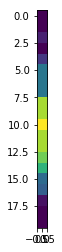

1.0208333
[1.        0.9875887 0.95      1.       ] [0.9693878  0.98738945 0.95       1.        ] [0.93877566 0.9973939  0.95       1.        ]
(64000, 4) (64000, 24, 24, 3)


In [8]:
x_train = train_data.reshape(-1, 24,24,3)
x_val = eval_data.reshape(-1, 24,24,3)
x_test = test_data.reshape(-1, 24,24,3)

y_train=np.abs(np.reshape(train_labels,(-1,4)))
y_val=np.abs(np.reshape(eval_labels,(-1,4)))
y_test=np.abs(np.reshape(test_labels,(-1,4)))

plt.imshow(-np.reshape(test_labels,(20,1,4))[:,:,0])
plt.show()
y_max=max(np.max(y_train[:,0]),np.max(y_val[:,0]))  #maximum observed chirality
y_train[:,0]=y_train[:,0]/y_max
y_val[:,0]=y_val[:,0]/y_max
y_test[:,0]=y_test[:,0]/y_max
print(y_max)
print(np.amax(y_train,axis=0),np.amax(y_val,axis=0),np.amax(y_test,axis=0))
print(np.shape(y_train),np.shape(x_train))

In [9]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (6, 6), activation='relu', input_shape = (24, 24, 3)))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.5))

model.add(Dense(4, activation='sigmoid'))

In [10]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4))#, metrics=["accuracy"]) #binary_crossentropy

In [11]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [12]:
hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val, y_val), #For speed
                           callbacks=[annealer])

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
 - 182s - loss: 0.0218 - val_loss: 0.0077
Epoch 2/10
 - 141s - loss: 0.0051 - val_loss: 0.0060
Epoch 3/10
 - 115s - loss: 0.0043 - val_loss: 0.0074
Epoch 4/10
 - 114s - loss: 0.0040 - val_loss: 0.0052
Epoch 5/10
 - 8094s - loss: 0.0037 - val_loss: 0.0034
Epoch 6/10
 - 73s - loss: 0.0036 - val_loss: 0.0038
Epoch 7/10
 - 67s - loss: 0.0034 - val_loss: 0.0029
Epoch 8/10
 - 65s - loss: 0.0033 - val_loss: 0.0031
Epoch 9/10
 - 63s - loss: 0.0033 - val_loss: 0.0029
Epoch 10/10
 - 64s - loss: 0.0032 - val_loss: 0.0028


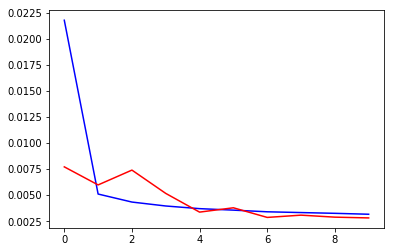

In [13]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [14]:
y_hat = model.predict(x_val)

In [15]:
(np.sum((y_val-y_hat)**2,axis=0)/(20*20*40))**0.5

array([0.06600364, 0.0400965 , 0.05355139, 0.04924173], dtype=float32)

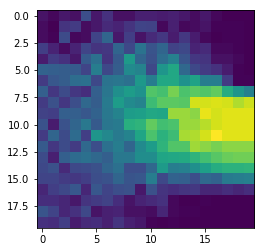

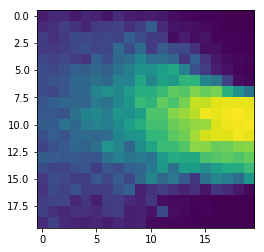

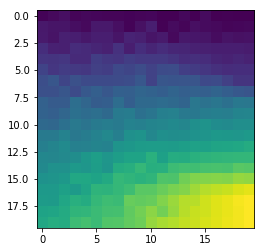

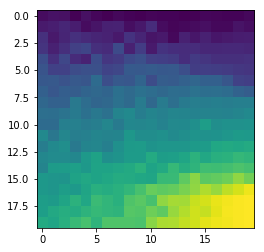

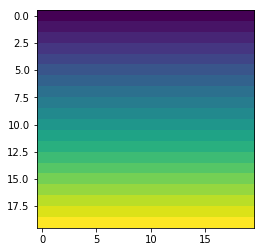

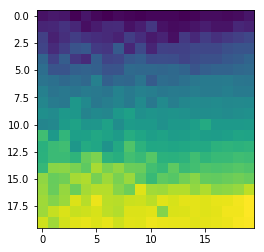

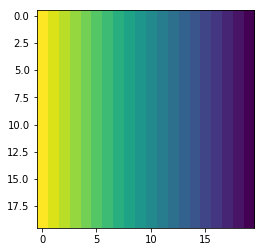

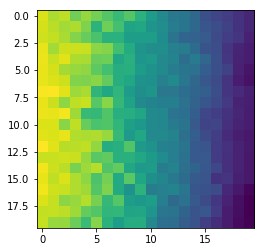

(20, 20, 40, 4)


In [16]:
y_val=np.reshape(y_val,(20,20,40,4))
y_hat=np.reshape(y_hat,(20,20,40,4))

plt.imshow(y_val[:,:,20,0])
plt.show()
plt.imshow(y_hat[:,:,20,0])
plt.show()

plt.imshow(y_val[:,:,20,1])
plt.show()
plt.imshow(y_hat[:,:,20,1])
plt.show()

plt.imshow(y_val[:,:,20,2])
plt.show()
plt.imshow(y_hat[:,:,20,2])
plt.show()

plt.imshow(y_val[:,:,20,3])
plt.show()
plt.imshow(y_hat[:,:,20,3])
plt.show()

print(np.shape(y_hat))

In [17]:
y_hat = model.predict(x_test)

In [18]:
#Error Analysis
y_hat=np.reshape(y_hat,(-1,4))
y_test=np.reshape(y_test,(-1,4))
n=np.shape(y_test)[0]

print(np.mean(y_hat-y_test,axis=0))

print((np.sum((y_hat-y_test)**2,axis=0)/(n))**0.5)

[-0.06823872  0.02223847  0.063616   -0.93041503]
[0.12542728 0.03903974 0.08938033 0.9307397 ]


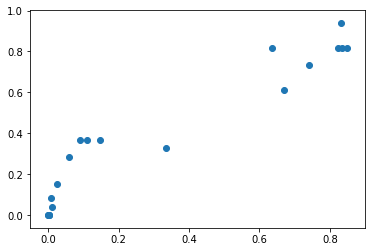

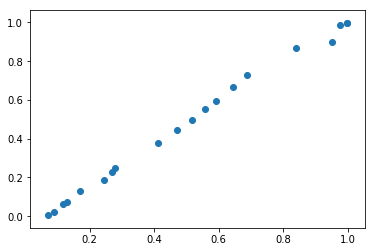

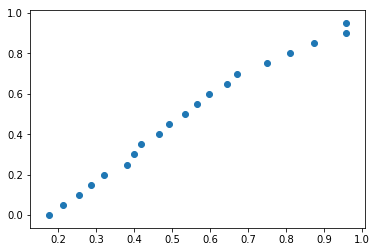

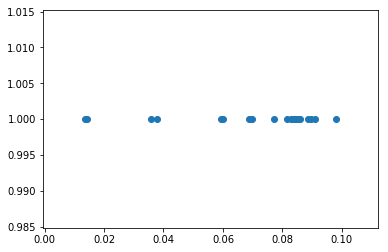

In [19]:
for i in range(4):
    plt.show(plt.scatter(y_hat[:,i],y_test[:,i]))

In [20]:
(np.sum(np.sum((y_test-y_hat)**2,axis=0),axis=0)/(20*20))**0.5

0.21113044109300755

In [21]:
y_test=np.reshape(y_test,(20,4))
y_hat=np.reshape(y_hat,(20,4))

In [22]:
'''x=np.arange(0,4,4/20)
plt.plot(x,y_test[:,19,0],'r')
plt.scatter(x,y_hat[:,19,0])
plt.show()

plt.plot(x,y_test[:,19,1],'r')
plt.scatter(x,y_hat[:,19,1])
plt.show()

plt.plot(x,4*y_test[:,19,2],'r')
plt.plot(x,3.6*np.ones(20),'g')
plt.scatter(x,4*y_hat[:,19,2])
plt.show()

x=np.arange(2,0,-0.1)
plt.plot(x,2*y_test[0,:,3],'r')
plt.plot(x,1.8*np.ones(20),'g')
plt.scatter(x,2*y_hat[0,:,3])
plt.show()
'''

"x=np.arange(0,4,4/20)\nplt.plot(x,y_test[:,19,0],'r')\nplt.scatter(x,y_hat[:,19,0])\nplt.show()\n\nplt.plot(x,y_test[:,19,1],'r')\nplt.scatter(x,y_hat[:,19,1])\nplt.show()\n\nplt.plot(x,4*y_test[:,19,2],'r')\nplt.plot(x,3.6*np.ones(20),'g')\nplt.scatter(x,4*y_hat[:,19,2])\nplt.show()\n\nx=np.arange(2,0,-0.1)\nplt.plot(x,2*y_test[0,:,3],'r')\nplt.plot(x,1.8*np.ones(20),'g')\nplt.scatter(x,2*y_hat[0,:,3])\nplt.show()\n"

In [25]:
'''from scipy.optimize import curve_fit

def func(x,a):
    return x*a

key=15

y=4*np.array(y_hat[:key,19,2])
x=np.arange(0,1,1/20)[:key]
a, err = curve_fit(func,x,y)
print(a, err)
print(((np.sum((a*x-y)**2)/key)**0.5)/4)

plt.plot(x,a*x,'r--')
#plt.scatter(x,a*x+0.8*(np.random.rand(key)-0.5))
plt.scatter(x,y)
plt.show()
'''

"from scipy.optimize import curve_fit\n\ndef func(x,a):\n    return x*a\n\nkey=15\n\ny=4*np.array(y_hat[:key,19,2])\nx=np.arange(0,1,1/20)[:key]\na, err = curve_fit(func,x,y)\nprint(a, err)\nprint(((np.sum((a*x-y)**2)/key)**0.5)/4)\n\nplt.plot(x,a*x,'r--')\n#plt.scatter(x,a*x+0.8*(np.random.rand(key)-0.5))\nplt.scatter(x,y)\nplt.show()\n"

In [37]:
'''key=7

y=2*np.array(y_hat[0,20-key:,3])
x=np.arange(2,0,-0.1)[20-key:]    
a, err = curve_fit(func,x,y)
print(a, err)
print(((np.sum((a*x-y)**2)/key)**0.5)/2)

plt.plot(x,a*x,'r--')
plt.scatter(x,y)
plt.show()'''

"key=7\n\ny=2*np.array(y_hat[0,20-key:,3])\nx=np.arange(2,0,-0.1)[20-key:]    \na, err = curve_fit(func,x,y)\nprint(a, err)\nprint(((np.sum((a*x-y)**2)/key)**0.5)/2)\n\nplt.plot(x,a*x,'r--')\nplt.scatter(x,y)\nplt.show()"

In [38]:
'''def fn(x,a):
    return x*a

x=np.log([1,2,3,4])
y=np.log([0.988, 1.838, 2.268, 2.604])
a, err=curve_fit(fn,x,y)
print(a,err)
plt.plot(x,x*a)
plt.scatter(x,y)
plt.show()

x=np.log([1,2,3,4])
y=np.log([0.988, 6.06, 12.92, 22.44])
a, err=curve_fit(fn,x,y)
print(a,err)
plt.plot(x,x*a)
plt.scatter(x,y)
plt.show()'''

'def fn(x,a):\n    return x*a\n\nx=np.log([1,2,3,4])\ny=np.log([0.988, 1.838, 2.268, 2.604])\na, err=curve_fit(fn,x,y)\nprint(a,err)\nplt.plot(x,x*a)\nplt.scatter(x,y)\nplt.show()\n\nx=np.log([1,2,3,4])\ny=np.log([0.988, 6.06, 12.92, 22.44])\na, err=curve_fit(fn,x,y)\nprint(a,err)\nplt.plot(x,x*a)\nplt.scatter(x,y)\nplt.show()'

In [28]:
W=model.get_weights()

In [29]:
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    print(g)
    print(np.shape(h))

{'name': 'conv2d_1', 'trainable': True, 'batch_input_shape': (None, 24, 24, 3), 'dtype': 'float32', 'filters': 16, 'kernel_size': (6, 6), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(2,)
{'name': 'batch_normalization_1', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}

In [30]:
for i in range(18):
    print(np.shape(W[i]))

(6, 6, 3, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(3, 3, 16, 32)
(32,)
(32,)
(32,)
(32,)
(32,)
(288, 512)
(512,)
(512, 1024)
(1024,)
(1024, 4)
(4,)


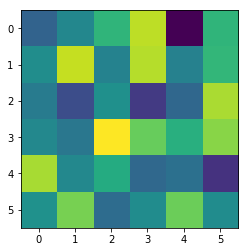

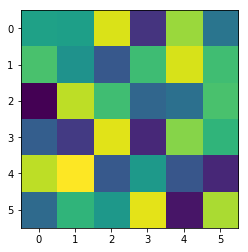

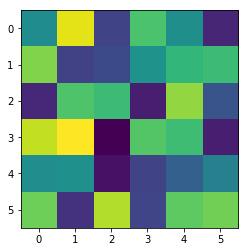

In [31]:
for i in range(3):
    plt.imshow(W[0][:,:,i,0])
    plt.show()

In [32]:
np.savetxt('Weight.csv',np.reshape(W[0],(1,-1)),delimiter=',')

In [33]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [34]:
print(K.learning_phase())
for i in range(16):
    print(outputs[i])

Tensor("batch_normalization_1/keras_learning_phase:0", shape=(), dtype=bool)
Tensor("conv2d_1/Relu:0", shape=(?, 19, 19, 16), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 19, 19, 16), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("dropout_1/cond/Merge:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("dropout_2/cond/Merge:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(?, 512), dtype=float32)
Tensor("leaky_re_lu_1/LeakyRelu:0", shape=(?, 512), dtype=float32)
Tensor("dropout_3/cond/Merge:0", shape=(?, 512), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 1024), dtype=float32)
Tensor("leaky_re_lu_2/LeakyRelu:0", shape=

In [43]:
# Testing
test = x_test[0,:,:,:][np.newaxis,...]
#test=np.random.rand(1,24,24,3)
layer_outs = [func([test, 0]) for func in functors]
#print(layer_outs)

In [44]:
for i in range(16):
    print(np.shape(layer_outs[i]))
    
np.savetxt("Out_SP0.csv",np.reshape(test[0,:,:,:],-1),delimiter=',')
np.savetxt("Out_SP1.csv",np.reshape(layer_outs[1],-1),delimiter=',')
np.savetxt("Out_SP2.csv",np.reshape(layer_outs[5],-1),delimiter=',')
np.savetxt("Out_SP3.csv",np.reshape(layer_outs[8],-1),delimiter=',')
np.savetxt("Out_SP4.csv",np.reshape(layer_outs[11],-1),delimiter=',')
np.savetxt("Out_SP5.csv",np.reshape(layer_outs[14],-1),delimiter=',')

(1, 1, 19, 19, 16)
(1, 1, 19, 19, 16)
(1, 1, 9, 9, 16)
(1, 1, 9, 9, 16)
(1, 1, 7, 7, 32)
(1, 1, 7, 7, 32)
(1, 1, 3, 3, 32)
(1, 1, 3, 3, 32)
(1, 1, 288)
(1, 1, 512)
(1, 1, 512)
(1, 1, 512)
(1, 1, 1024)
(1, 1, 1024)
(1, 1, 1024)
(1, 1, 4)


In [ ]:
print(np.shape(test))
plt.imshow(test[0,:,:,2])
plt.show()
for i in range(8):
    print(np.shape(layer_outs[i]), np.sum(np.array(layer_outs[i])[0,0,:,:,0]))
    plt.imshow(np.array(layer_outs[i])[0,0,:,:,0])
    plt.show()
    


In [ ]:
for i in range(8,15):
    plt.plot(np.sort(np.array(layer_outs[i])[0,0,:]))
    plt.show()
print(np.array(layer_outs[15])[0,0,:])

In [ ]:
print(K.learning_phase())